# ST2195 Coursework, Jupyter Notebook (Python)
Student Number: 190399205

2/22/2022

### ST2195 Programming for Data Science Coursework

## Importing and loading data.
To start off, we load the following packages which we will use to answer the following questions. Then, we set the working directory that contains the required files, and read the files into dataframes.

In [1]:
import sqlite3
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import random
import numpy as np

In [2]:
from sklearn.metrics import r2_score

Then, we set the working directory that contains the required files. We use pandas to read the .csv files and store them into their respective data frames.

In [3]:
# change to the directory where the files are stored
os.chdir("D:/SIM-UOL/YEAR 3/ST2195 Programming for Data Science/Coursework/SITINURBALQIS/python")

# create dataframes airports, carriers, planes
airports = pd.read_csv("airports.csv")
carriers = pd.read_csv("carriers.csv")
planes = pd.read_csv("plane-data.csv")
# create dataframes year2003, year2004
year2003 = pd.read_csv("2003.csv", low_memory = False)
year2004 = pd.read_csv("2004.csv", low_memory = False)

## Creating the database.
We create a database, connect it to DBI Browser (SQLite) using sqlite3, and create tables by writing the data frames to the database.

In [4]:
# Remove airline.db if present
try:
    os.remove('airline.db')
except OSError:
    pass

# ------- create database -------
conn = sqlite3.connect('airline.db')

In [5]:
# ------- create tables -------
airports.to_sql('airports', con = conn, index = False)
carriers.to_sql('carriers', con = conn, index = False)
planes.to_sql('planes', con = conn, index = False)

c = conn.cursor()
c.execute('''
CREATE TABLE yearsdf (
  Year int,
  Month int,
  DayofMonth int,
  DayOfWeek int,
  DepTime  int,
  CRSDepTime int,
  ArrTime int,
  CRSArrTime int,
  UniqueCarrier varchar(5),
  FlightNum int,
  TailNum varchar(8),
  ActualElapsedTime int,
  CRSElapsedTime int,
  AirTime int,
  ArrDelay int,
  DepDelay int,
  Origin varchar(3),
  Dest varchar(3),
  Distance int,
  TaxiIn int,
  TaxiOut int,
  Cancelled int,
  CancellationCode varchar(1),
  Diverted varchar(1),
  CarrierDelay int,
  WeatherDelay int,
  NASDelay int,
  SecurityDelay int,
  LateAircraftDelay int
)
''')
conn.commit()


year2003.to_sql('yearsdf', con = conn, if_exists = 'append', index = False)
year2004.to_sql('yearsdf', con = conn, if_exists = 'append', index = False)

7129270

 Afterwards, we partly clean the main table and create copies of it to be used in Q3, Q4, and Q5.

In [6]:
# Clean ArrDelay and DepDelay
c.execute(''' 
          DELETE FROM yearsdf
          WHERE ArrDelay IS NULL OR trim(ArrDelay) = ''
          AND DepDelay IS NULL OR trim(DepDelay) = ''
          ''')
conn.commit()

In [7]:
# Create Table for Question 3, 4, 5 in database
c.execute('''
          CREATE TABLE yearsdf3 \
          AS SELECT * FROM yearsdf''')

c.execute('''
          CREATE TABLE yearsdf4 \
          AS SELECT * FROM yearsdf''')

c.execute('''
          CREATE TABLE Q5flights \
          AS SELECT * FROM yearsdf''')
conn.commit()

## Queries via DBI:

### Question 1
Here, we further clean the data by omitting rows with Cancelled or Diverted flights.

In [8]:
# Delete rows with Cancelled or Diverted flights
c.execute('''
          DELETE FROM yearsdf \
          WHERE Cancelled = 1 OR Diverted = 1''')
conn.commit()

### The following is how we approach the Question: ***When is the best time of day to fly to minimise delays?***

We select the variables Year, Month, DayofMonth, DayofWeek, DepTime, ArrDelay and DepDelay from main table yearsdf and return a query as Q1flights data frame. 

We also check for any NAs as we will be using ArrDelay as the assumed delays mentioned.

In [9]:
Q1flights = c.execute('''
                      SELECT Year, Month, DayofMonth, DayofWeek, DepTime, ArrDelay, DepDelay \
                      FROM yearsdf
                      ''').fetchall()

# Convert from list to dataframe
Q1flights = pd.DataFrame(Q1flights, columns = ['Year', 'Month', 'DayofMonth', 'DayofWeek', 'DepTime', 'ArrDelay', 'DepDelay'])

# Check for NAs in entire dataframe
Q1flights.isnull().values.any()


False

Next, we create a new column ‘category’ that stores the categorised timing intervals of DepTime according to Morning, Afternoon, Evening, and Night, using the if else condition.
The code is adapted from: https://stackoverflow.com/questions/63071619/how-to-categorize-timestamp-into-evening-in-pandas-dataframe

In [10]:
def categories(row):
    if row['DepTime'] > 499 and row['DepTime'] <= 1159:
        return 'Morning'
    elif row['DepTime'] > 1159 and row['DepTime'] <= 1659:
        return 'Afternoon'
    elif row['DepTime'] > 1659  and row['DepTime'] <= 2059:
        return 'Evening'
    else:
        return 'Night'

Q1flights['category'] = Q1flights.apply(lambda row: categories(row), axis=1)

# Check data types of Q1flights data frame
dataTypeSeries = Q1flights.dtypes
print(dataTypeSeries)

Year           int64
Month          int64
DayofMonth     int64
DayofWeek      int64
DepTime        int64
ArrDelay       int64
DepDelay       int64
category      object
dtype: object


We write the Q1flights data frame into the database and create table 'Q1flights'.

Next, we query the variables category and the averaged ArrDelay from Q1flights table and return into timeofday data frame.

We also round variable Mean_ArrDelay to 3 decimal places.

In [11]:
Q1flights.to_sql('Q1flights', con = conn, if_exists = 'append', index = False)

timeofday = c.execute('''
                      SELECT category, AVG(ArrDelay) AS Mean_ArrDelay \
                      FROM Q1flights \
                      GROUP BY category \
                      ORDER BY Mean_ArrDelay
                      ''').fetchall()

# Convert timeofday from list to data frame, rename category as Category
timeofday = pd.DataFrame(timeofday, columns = ['Category', 'Mean_ArrDelay'])
timeofday['Mean_ArrDelay'] = round(timeofday['Mean_ArrDelay'], 3)

We plot a bar chart to view the Average Arrival Flight Delay per Time of Day using matplotlib and seaborn packages.
The codes are adapted from: https://www.delftstack.com/howto/seaborn/size-of-seaborn-plot/

In [12]:
%matplotlib inline

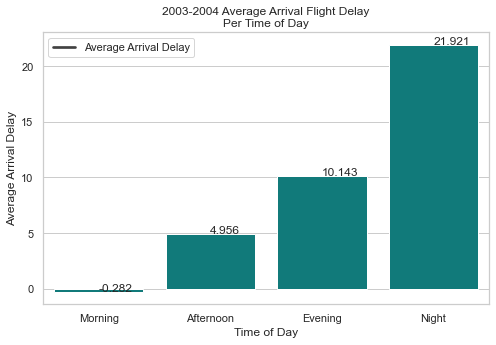

In [13]:
sns.set(rc = {'figure.figsize':(8,5)})
sns.set_theme(style="whitegrid")
Category_barchat = sns.barplot(x="Category", y="Mean_ArrDelay", data = timeofday,
                               color = "darkcyan").set(title='2003-2004 Average Arrival Flight Delay\nPer Time of Day')
plt.xlabel("Time of Day")
plt.ylabel("Average Arrival Delay")
plt.legend(labels=["Average Arrival Delay"])
for index, value in enumerate(timeofday['Mean_ArrDelay']):
    plt.text(index,value, str(value))

We print an output for Time of Day that has lowest mean.
The following code is adapted from: https://stackoverflow.com/questions/61801654/pandas-get-value-based-on-minimum-value-in-other-column

In [14]:
print(timeofday.loc[timeofday['Mean_ArrDelay'].idxmin()]['Category'], "is the best time of day to fly to minimise delays.")

Morning is the best time of day to fly to minimise delays.


### The following is how we approach the Question: ***When is the best day of the week to fly to minimise delays?***

We retrieve the variables DayOfWeek and the averaged ArrDelay from table Q1flights into dayofweek data frame. This code is based on: https://stackoverflow.com/questions/30482071/how-to-calculate-mean-values-grouped-on-another-column-in-pandas.

We also map the numeric values of the day of the week to their weekday name and round variable Mean_ArrDelay to 3 decimal places.

In [15]:
# Find average ArrDelay, group by Day of Week
dayofweek = Q1flights.groupby('DayofWeek', as_index=False)['ArrDelay'].mean()

# Retrieve day of week from int
days = {1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday', 7:'Sunday'}
# Map day of week to int
dayofweek['DayofWeek'] = dayofweek['DayofWeek'].map(days)

# Rename ArrDelay to Mean_ArrDelay
dayofweek.rename(columns={"ArrDelay": "Mean_ArrDelay"}, inplace=True)
dayofweek['Mean_ArrDelay'] = round(dayofweek['Mean_ArrDelay'], 3)

We plot a bar chart to view the Average Arrival Flight Delay per Day.

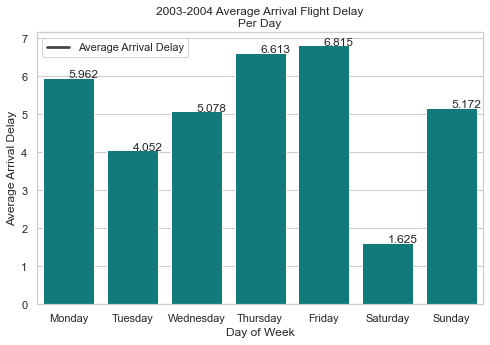

In [16]:
sns.set(rc = {'figure.figsize':(8,5)})
sns.set_theme(style="whitegrid")
DayofWeek_barchat = sns.barplot(x="DayofWeek", y="Mean_ArrDelay", data = dayofweek,
                               color = "darkcyan").set(title='2003-2004 Average Arrival Flight Delay\nPer Day')
plt.xlabel("Day of Week")
plt.ylabel("Average Arrival Delay")
plt.legend(labels=["Average Arrival Delay"])
for index, value in enumerate(dayofweek['Mean_ArrDelay']):
    plt.text(index,value, str(value))

In [17]:
print(dayofweek.loc[dayofweek['Mean_ArrDelay'].idxmin()]['DayofWeek'], "is the best day of the week to fly to minimise delays.")

Saturday is the best day of the week to fly to minimise delays.


### The following is how we approach the Question: ***When is the best time of year to fly to minimise delays?***

We retrieve the variables Month and the averaged ArrDelay from table Q1flights into timeofyear data frame.

We also map the numeric values of the month to their month name and round variable Mean_ArrDelay to 3 decimal places.

In [18]:
# Find average ArrDelay group by Month
timeofyear = Q1flights.groupby('Month', as_index=False)['ArrDelay'].mean()

# Retrieve Month from int
days = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}
# Map map to int
timeofyear['Month'] = timeofyear['Month'].map(days)

# Rename ArrDelay to Mean_ArrDelay
timeofyear.rename(columns={"ArrDelay": "Mean_ArrDelay"}, inplace=True)
# Round up mean_arrdelay to 3 decimals
timeofyear['Mean_ArrDelay'] = (round(timeofyear['Mean_ArrDelay'], 3))

We plot a bar chart to view the Average Arrival Flight Delay per Month.

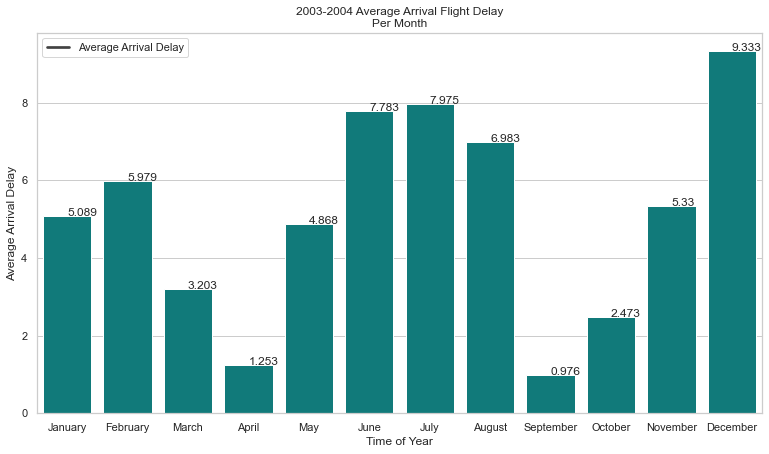

In [19]:
sns.set(rc = {'figure.figsize':(13,7)})
sns.set_theme(style="whitegrid")
timeofyear_barchat = sns.barplot(x="Month", y="Mean_ArrDelay", data = timeofyear,
                               color = "darkcyan").set(title='2003-2004 Average Arrival Flight Delay\nPer Month')
plt.xlabel("Time of Year")
plt.ylabel("Average Arrival Delay")
plt.legend(labels=["Average Arrival Delay"])
for index, value in enumerate(timeofyear['Mean_ArrDelay']):
    plt.text(index,value, str(value))

In [20]:
print(timeofyear.loc[timeofyear['Mean_ArrDelay'].idxmin()]['Month'], "is the best time of year to fly to minimise delays.")

September is the best time of year to fly to minimise delays.


### Question 2

### ***Do older planes suffer more delays?***

We merge the years of flights, which is the yearsdf table, and the planes tables using inner join with variable TailNum as the matching value and query into planes_age data frame.

In [21]:
# Select and import data from yearsdf table inner join planes table,
# into a list converted to data frame called planes_age.

planes_age = c.execute('''
                      SELECT yearsdf.Year AS flight_year, \
                      yearsdf.ArrDelay, planes.year AS plane_year, \
                      yearsdf.TailNum \
                      FROM yearsdf \
                      INNER JOIN planes ON yearsdf.TailNum = planes.tailnum
                      ''').fetchall()
planes_age = pd.DataFrame(planes_age, columns = ['FlightYear', 'ArrDelay', 'PlaneYear', 'TailNum'])

Next, we would like to see the unique plane years and check if there are any odd values. The maximum year should be 2004.

In [22]:
# Check what years are in the column Plane Year
planes_age.PlaneYear.unique()

array(['1990', '1987', '1994', '2002', '1999', '1992', '1991', '1993',
       '2001', '1995', '1997', '1988', '1989', '1996', '1998', '2000',
       None, 'None', '1986', '1985', '1979', '1978', '1980', '1968',
       '1969', '1973', '1975', '1967', '1977', '1976', '1970', '1971',
       '0000', '2003', '1984', '1963', '1956', '2007', '1972', '1974',
       '1959', '1982', '1983', '1962', '1964', '1965', '1957', '1966',
       '2004'], dtype=object)

We can observe that there are a few odd years: empty cells, 0000, None, 2007.

Therefore, we clean the planes_age data frame by removing the odd years.
We also remove NA rows.

The following codes are adapted from: https://stackoverflow.com/questions/52456874/drop-rows-on-multiple-conditions-in-pandas-dataframe and https://stackoverflow.com/questions/49291740/delete-rows-if-there-are-null-values-in-a-specific-column-in-pandas-dataframe respectively.

In [23]:
planes_age = planes_age.loc[~((planes_age['PlaneYear'] == "None") | (planes_age['PlaneYear'] == "2007") | (planes_age['PlaneYear'] == "0000"))]

# Remove rows where PlaneYear = NAs
planes_age = planes_age.dropna(axis=0, subset=['PlaneYear'])

We convert PlaneYear data type from string to integer, and create a new column 'Age' which represents the age of plane that stores data after subtracting PlaneYear from FlightYear.

Afterwards, we write planes_age data frame into the database and create planes_age table.

We query the variables Age, where age is capped at 25, and the averaged ArrDelay from table planes_age and query into age_group data frame.

We round variable mean_ArrDelay to 3 decimal places.

In [24]:
planes_age['PlaneYear'] = planes_age['PlaneYear'].astype(int)

planes_age['Age'] = planes_age["FlightYear"] - planes_age["PlaneYear"]

planes_age.to_sql('planes_age', con = conn, if_exists = 'append', index = False)

# Create dataframe age_group with variables Age, average of ArrDelay from planes_age table where Age <= 25
age_group = c.execute('''
                      SELECT Age, avg(ArrDelay) AS mean_ArrDelay \
                      FROM planes_age \
                      WHERE Age <= 25 \
                      GROUP BY Age
                      ''').fetchall()
age_group = pd.DataFrame(age_group, columns = ['Age', 'mean_ArrDelay'])

# Round up mean_arrdelay to 3 decimals
age_group['mean_ArrDelay'] = (round(age_group['mean_ArrDelay'], 3))

We plot the data and a linear regression model fit to view the Average Arrival Flight Delay by Age Groups of Planes.

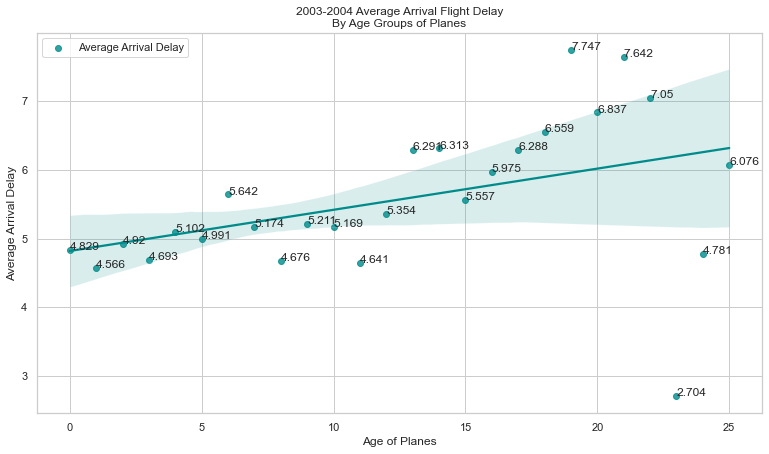

In [25]:
sns.set(rc = {'figure.figsize':(13,7)})
sns.set_theme(style="whitegrid")

ageofplane_plot = sns.regplot(x="Age", y="mean_ArrDelay", color = "darkcyan",
                              data = age_group).set(title='2003-2004 Average Arrival Flight Delay\nBy Age Groups of Planes');

plt.xlabel("Age of Planes")
plt.ylabel("Average Arrival Delay")
plt.legend(labels=["Average Arrival Delay"], loc='upper left')
for index, value in enumerate(age_group['mean_ArrDelay']):
    plt.text(index,value, str(value))

### Question 3

### ***How does the number of people flying between different locations change over time?***

Here, we omit the rows with cancelled flights from table yearsdf3.

In [26]:
# Delete rows with Cancelled flights from yearsdf3 -- copied yearsdf table
c.execute('''
          DELETE FROM yearsdf3 \
          WHERE Cancelled = 1 ''')
conn.commit()

We find which Origin has the highest number of flights by selecting Origin and the total count of FlightNum from table yearsdf3 and query it into Flights_GroupByOrigin data frame.

In [27]:
Flights_GroupByOrigin = c.execute('''
                      SELECT count(FlightNum) AS TotalFlights, Origin \
                      FROM yearsdf3 \
                      GROUP BY Origin \
                      ORDER BY TotalFlights
                      ''').fetchall()
Flights_GroupByOrigin = pd.DataFrame(Flights_GroupByOrigin, columns = ['TotalFlights', 'Origin'])

We find out that for Origin, ATL has the highest number of flights, with 773,319 flights in total.

Then, we retrieve all Destinations whose Origin is ATL by selecting the variables Dest, Month, and total count of FlightNum from table yearsdf3 where Origin is ATL and return a query as Flights_DestfromATL data frame.

We map the numeric values of the months to their month name and write the Flights_DestfromATL data frame into the data base to create table Flights_DestfromATL.

In [28]:
Flights_DestfromATL = c.execute('''
                      SELECT count(FlightNum) AS TotalFlights, Dest, Month \
                       FROM yearsdf3 \
                       WHERE Origin = 'ATL' \
                       GROUP BY Dest, Month
                      ''').fetchall()
Flights_DestfromATL = pd.DataFrame(Flights_DestfromATL, columns = ['TotalFlights', 'Dest', 'Month'])

# Retrieve Month from int
days = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}
# Map month to int
Flights_DestfromATL['Month'] = Flights_DestfromATL['Month'].map(days)

Flights_DestfromATL.to_sql('Flights_DestfromATL', con = conn, if_exists = 'append', index = False)

1773

We retrieve the variables Dest and the sum of TotalFlights from the Flights_DestfromATL table and query into totalflights data frame to find the top 5 destinations with highest number of flights.

In [29]:
# show total number of flights by dest
# create dataframe totalflights by including the sum of totalflights, Dest, from Flights_DestfromATL table
totalflights = c.execute('''
          SELECT sum(totalflights) AS TotalFlights, Dest
           FROM Flights_DestfromATL
           GROUP BY Dest
           ORDER BY TotalFlights
          ''')
totalflights = pd.DataFrame(totalflights, columns = ['TotalFlights', 'Dest'])

Here, we can see that the those top 5 destinations are: DFW, LGA, ORD, EWR, and MCO.

Hence, we create a new data frame Q3 that includes rows where Dest = DFW, LGA, ORD, EWR, or MCO from Flights_DestfromATL dataframe.

Finally, plot the data and draw a line plot to view the Total Number of Flights from ATL Per Month, by Destination.

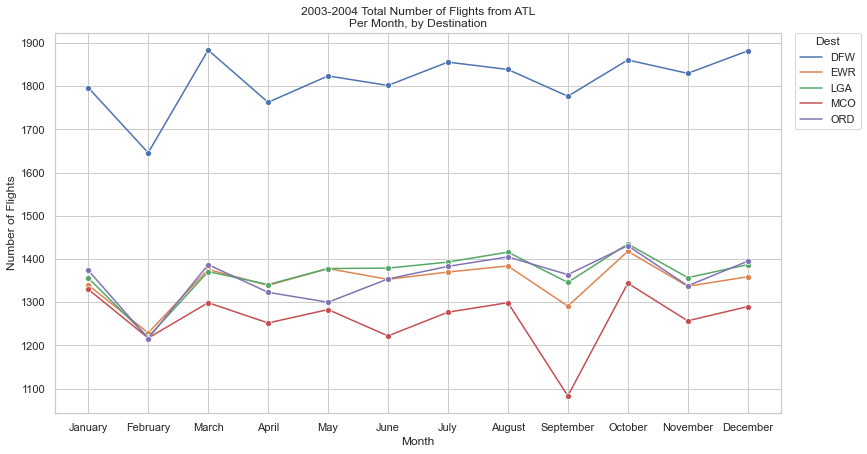

In [30]:
Q3 = Flights_DestfromATL.loc[Flights_DestfromATL['Dest'].isin(["DFW", "LGA", "ORD", "EWR", "MCO"])]

# Plot line graph
sns.set(rc = {'figure.figsize':(13,7)})
sns.set_theme(style="whitegrid")

changeovertime_linegraph = sns.lineplot(data = Q3, x = "Month", y = "TotalFlights",
                                        hue = "Dest", ci = None, marker = 'o',
                                        legend = "brief").set(title='2003-2004 Total Number of Flights from ATL\nPer Month, by Destination')

# Based on: https://www.statology.org/seaborn-legend-position/
plt.xlabel("Month")
plt.ylabel("Number of Flights")
plt.legend(title='Dest', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

### Question 4

### ***Can you detect cascading failures as delays in one airport create delays in others?***

Here, we omit the rows with cancelled flights.

In [31]:
# Delete rows with Cancelled flights
c.execute('''
          DELETE FROM yearsdf4 \
           WHERE Cancelled = 1 ''')
conn.commit()

Next, we select the variables Year, Month, DayofMonth, DepTime, CRSDepTime, ArrTime, CRSArrtime, FlightNum, TailNum, ArrDelay, DepDelay, Origin, Dest, LateAircraftDelay from yearsdf4 table on the condition that ArrDelay and LateAircraftDelay are greater than 0, and return the query into data frame ‘delays’.

In [32]:
delays = c.execute('''
                   SELECT Year, Month, DayofMonth, DepTime,
                    CRSDepTime, ArrTime, CRSArrtime, FlightNum, TailNum,
                    ArrDelay, DepDelay, Origin, Dest, LateAircraftDelay
                    FROM yearsdf4
                    WHERE ArrDelay > 0 AND LateAircraftDelay > 0
                   ''')
delays = pd.DataFrame(delays, columns = ['Year', 'Month', 'DayofMonth', 'DepTime',
                                         'CRSDepTime', 'ArrTime', 'CRSArrTime', 'FlightNum',
                                         'TailNum', 'ArrDelay', 'DepDelay', 'Origin', 'Dest',
                                         'LateAircraftDelay'])

We filter the delays data frame by only including data where DepDelay is greater than 0 into a new data frame ‘latedep’.

Then, we check which Destination has the highest number of flights.

In [33]:
latedep = delays[delays['DepDelay'] > 0]

latedep['Dest'].value_counts()

ORD    53942
ATL    38915
DFW    33815
LAS    25617
LAX    24027
       ...  
LWB       14
IYK       11
GUC       11
APF       10
WYS        5
Name: Dest, Length: 277, dtype: int64

According to the output, ORD has the highest number of flights.

With this information, we create two new data frames, ‘cascadingDest’ and ‘cascadingOri’, which will include data from latedep data frame where Dest and Origin variables are ‘ORD’ respectively.

We merge the two data frames together into data frame ‘cascadingDelay’.

cascadingDelayfiltered data frame is created by filtering and retrieving data where year is 2003, month is 12 and day of month is 12.

In [34]:
cascadingDest = latedep[latedep['Dest'] == 'ORD']
cascadingOri = latedep[latedep['Origin'] == 'ORD']

# Join dataframes to create cascadingDelay dataframe
frames = [cascadingDest, cascadingOri]
cascadingDelay = pd.concat(frames)

# filter flights where year = 2003, month = 12 and dayofmonth = 12
cascadingDelayfiltered = cascadingDelay.loc[(cascadingDelay["Year"] == 2003) & (cascadingDelay["Month"] == 6) & (cascadingDelay["DayofMonth"] == 12)]

# sort according to respective columns
cascadingDelayfiltered = cascadingDelayfiltered.sort_values(by=["Year", "Month", "DayofMonth", "TailNum"])

### Question 5

### ***Use the available variables to construct a model that predicts delays.***

We select the variables ArrDelay, DepDelay, CarrierDelay, WeatherDelay, NASDelay, SecurityDelay and LateAircraftDelay from Q5flights table on the condition that flights are not cancelled nor diverted, and return the query into data frame ‘Q5flights’.

Then, we conduct a Simple Linear Regression based on: https://bookdown.org/fjmcgrade/ismaykim/6-regression.html

In [35]:
Q5flights = c.execute('''
                   SELECT ArrDelay, DepDelay, CarrierDelay,
                   WeatherDelay, NASDelay, SecurityDelay,
                   LateAircraftDelay
                   FROM Q5flights
                   WHERE CANCELLED = 0 AND DIVERTED = 0
                   ''')
Q5flights = pd.DataFrame(Q5flights, columns = ['ArrDelay', 'DepDelay', 'CarrierDelay', 'WeatherDelay',
                                               'NASDelay', 'SecurityDelay', 'LateAircraftDelay'])


We create a copy of the Q5flights data frame and name it 'flightprediction'.
Then, we check and remove for NAs.
Lastly, we create a new data frame 'flightpreddf' that include variables ArrDelay and DepDelay from flightprediction dataframe.

In [36]:
# Create copy of dataframe
flightprediction = Q5flights.copy()

flightprediction = flightprediction[flightprediction['CarrierDelay'].notna()]
flightprediction = flightprediction[flightprediction['WeatherDelay'].notna()]
flightprediction = flightprediction[flightprediction['NASDelay'].notna()]
flightprediction = flightprediction[flightprediction['SecurityDelay'].notna()]
flightprediction = flightprediction[flightprediction['LateAircraftDelay'].notna()]

flightpreddf = flightprediction[['ArrDelay', 'DepDelay']].copy()

Data frame 'prediction' is created by choosing a random sample of 50 from flightpreddf dataframe to create a simple linear regression model.
We round our prediction statistical data to 1 decimal place.

In [44]:
# set seed
random.seed(3)

# Choose random 50 samples
prediction = flightpreddf.sample(50)

prediction.describe().round(1)

,ArrDelay,DepDelay
count,50.0,50.0
mean,12.0,12.9
std,41.0,35.8
min,-32.0,-10.0
25%,-10.0,-3.8
50%,0.5,0.0
75%,15.8,18.0
max,225.0,204.0


We plot the data and a linear regression model fit.

Text(0, 0.5, 'Arrival Delay')

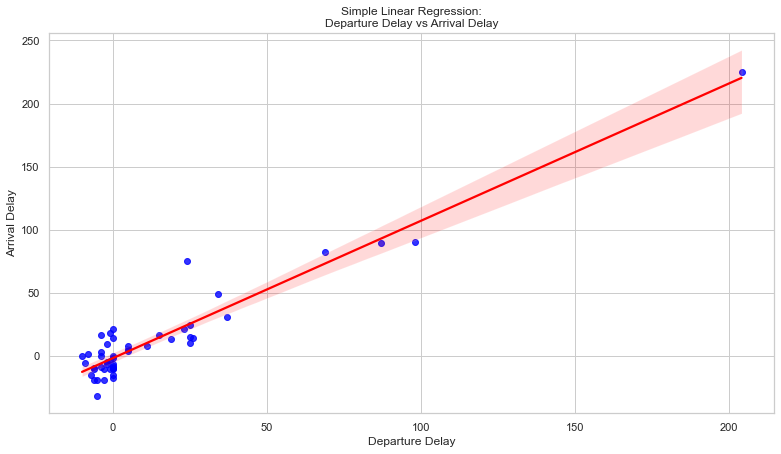

In [45]:
lm_plot = sns.regplot(x = "DepDelay", y = "ArrDelay", data = prediction,
                      scatter_kws = {"color": "blue"}, line_kws = {"color": "red"})
plt.title('Simple Linear Regression:\nDeparture Delay vs Arrival Delay')
plt.xlabel('Departure Delay')
plt.ylabel('Arrival Delay')


We fit the Linear Regression to the prediction data and find our respective statistical measures.
The following codes are adapted from: https://towardsdatascience.com/r-vs-python-linear-regression-b9cfc6d1407c

In [46]:
model = LinearRegression()
model.fit(prediction[['DepDelay']], prediction[['ArrDelay']])

LinearRegression()

In [47]:
# R Squared
r2_score(prediction[['DepDelay']], prediction[['ArrDelay']]).round(5)

0.86429

In [48]:
# Adjusted R-squared
model.score(prediction[['DepDelay']], prediction[['ArrDelay']]).round(5)

0.90338

In [49]:
print(model.intercept_)

[-1.99815445]


In [50]:
print(model.coef_)

[[1.08991882]]


This concludes the end of this coursework.